# Импорт необходимых библиотек:

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import urllib.request
import tarfile
from shutil import copyfile
from PIL import Image

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score

In [ ]:
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
file_name = "images.tar.gz"

urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

os.remove(file_name)
print("Архив успешно удален.")

folder_path = 'images'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

Файл успешно скачан.
Архив успешно разархивирован.
Архив успешно удален.


# Предобработка и визуализация данных:

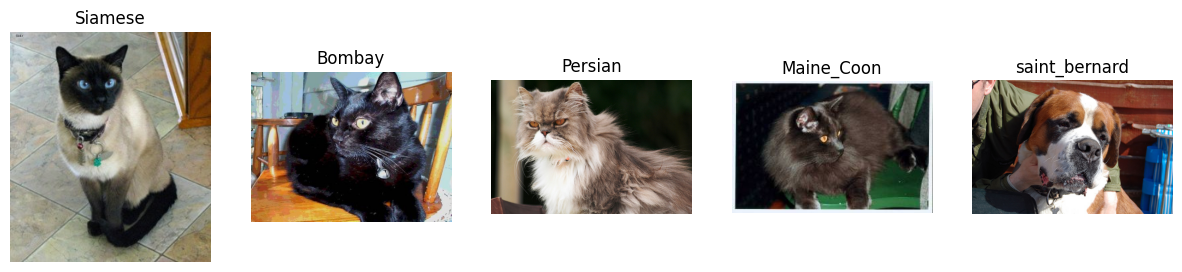

In [ ]:
def visualize_pet_images(folder_path, num_images=5):
    plt.figure(figsize=(15, 8))

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    selected_images = random.sample(pet_images, num_images)

    for i, image in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image)
        breed = '_'.join(image.split('_')[:-1])

        img = mpimg.imread(image_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(breed)
        plt.axis('off')

    plt.show()

visualize_pet_images(folder_path, num_images=5)

In [ ]:
def count_images(folder_path):
    total_count = 0
    breed_counts = {}

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    for image in pet_images:
        breed = '_'.join(image.split('_')[:-1])
        breed_counts[breed] = breed_counts.get(breed, 0) + 1
        total_count += 1

    return total_count, breed_counts

total_count, breed_counts = count_images(folder_path)

print("Общее количество фотографий:", total_count)
print("Количество фотографий для каждой породы:")
for breed, count in breed_counts.items():
    print(f"{breed}: {count}")

Общее количество фотографий: 7390
Количество фотографий для каждой породы:
Abyssinian: 200
american_bulldog: 200
american_pit_bull_terrier: 200
basset_hound: 200
beagle: 200
Bengal: 200
Birman: 200
Bombay: 200
boxer: 200
British_Shorthair: 200
chihuahua: 200
Egyptian_Mau: 200
english_cocker_spaniel: 200
english_setter: 200
german_shorthaired: 200
great_pyrenees: 200
havanese: 200
japanese_chin: 200
keeshond: 200
leonberger: 200
Maine_Coon: 200
miniature_pinscher: 200
newfoundland: 200
Persian: 200
pomeranian: 200
pug: 200
Ragdoll: 200
Russian_Blue: 200
saint_bernard: 200
samoyed: 200
scottish_terrier: 199
shiba_inu: 200
Siamese: 200
Sphynx: 200
staffordshire_bull_terrier: 191
wheaten_terrier: 200
yorkshire_terrier: 200


In [ ]:
images_folder = "images"
split_folder = "images_split"
if not os.path.exists(split_folder):
    os.makedirs(split_folder)

train_folder = os.path.join(split_folder, "train")
test_folder = os.path.join(split_folder, "test")
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

image_files = os.listdir(images_folder)
random.shuffle(image_files)

train_count = int(len(image_files) * 0.8)
test_count = len(image_files) - train_count

train_counter = 0
test_counter = 0

for image_file in image_files:
    breed = '_'.join(image_file.split('_')[:-1])
    source_path = os.path.join(images_folder, image_file)
    if train_counter < train_count:
        destination_folder = os.path.join(train_folder, breed)
        train_counter += 1
    else:
        destination_folder = os.path.join(test_folder, breed)
        test_counter += 1
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    destination_path = os.path.join(destination_folder, image_file)
    copyfile(source_path, destination_path)

print("Количество файлов в папке train:", train_counter)
print("Количество файлов в папке test:", test_counter)

Количество файлов в папке train: 5914
Количество файлов в папке test: 1479


In [ ]:
image_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    transforms.RandomRotation(20),  # Вращение изображения на случайный угол до 20 градусов
    transforms.RandomResizedCrop(image_size),  # Случайное масштабирование и обрезка изображения
    transforms.RandomHorizontalFlip(),  # Случайное отражение изображения по горизонтали
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Изменение цвета изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    #transforms.CenterCrop(image_size),  # Обрезка центральной части изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

train_data = datasets.ImageFolder(root="images_split/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="images_split/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(len(train_loader), len(test_loader))

(185, 47)

# Определение и обучение моделей:

In [ ]:
def change_model(model_base, num_classes, dropout_rate=0.5):

    for param in model_base.parameters():
        param.requires_grad = False

    if isinstance(model_base, models.VGG):
        num_features = model_base.classifier[-1].in_features
    elif isinstance(model_base, models.ResNet):
        num_features = model_base.fc.in_features

    if isinstance(model_base, models.VGG):
        model_base.classifier[-1] = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, num_classes),
            nn.Softmax(dim=1)
        )
    elif isinstance(model_base, models.ResNet):
        model_base.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, num_classes),
            nn.Softmax(dim=1)
        )

    return model_base

num_classes = 37

vgg16_base = models.vgg16(pretrained=True)
vgg19_base = models.vgg19(pretrained=True)
resnet50_base = models.resnet50(pretrained=True)

vgg16_model = change_model(vgg16_base, num_classes)
vgg19_model = change_model(vgg19_base, num_classes)
resnet50_model = change_model(resnet50_base, num_classes)

vgg16

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
train_loss_history_vgg16 = []
test_loss_history_vgg16 = []
train_acc_history_vgg16 = []
test_acc_history_vgg16 = []

In [ ]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение
    vgg16_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Переносим данные на GPU, если доступно
        images, labels = images.to(device), labels.to(device)
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Передаем данные через модель
        outputs = vgg16_model(images)
        # Вычисляем потери
        loss = criterion(outputs, labels)
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_vgg16.append(train_loss)
    train_acc_history_vgg16.append(train_accuracy)

    # Тестирование
    vgg16_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # Переносим данные на GPU, если доступно
            images, labels = images.to(device), labels.to(device)

            outputs = vgg16_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_vgg16.append(test_loss)
    test_acc_history_vgg16.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 3.6017, Train Acc: 5.79%, Test Loss: 3.5464, Test Acc: 34.89%
Epoch [2/10], Train Loss: 3.5363, Train Acc: 20.08%, Test Loss: 3.3427, Test Acc: 45.17%
Epoch [3/10], Train Loss: 3.4293, Train Acc: 32.26%, Test Loss: 3.1743, Test Acc: 56.19%
Epoch [4/10], Train Loss: 3.3458, Train Acc: 39.99%, Test Loss: 3.0867, Test Acc: 60.31%
Epoch [5/10], Train Loss: 3.2908, Train Acc: 44.15%, Test Loss: 3.0438, Test Acc: 63.02%
Epoch [6/10], Train Loss: 3.2472, Train Acc: 48.18%, Test Loss: 3.0068, Test Acc: 67.14%
Epoch [7/10], Train Loss: 3.2109, Train Acc: 51.48%, Test Loss: 2.9817, Test Acc: 69.98%
Epoch [8/10], Train Loss: 3.1913, Train Acc: 52.87%, Test Loss: 2.9572, Test Acc: 72.35%
Epoch [9/10], Train Loss: 3.1747, Train Acc: 53.98%, Test Loss: 2.9422, Test Acc: 73.09%
Epoch [10/10], Train Loss: 3.1589, Train Acc: 55.56%, Test Loss: 2.9301, Test Acc: 74.17%


vgg19

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=0.001, momentum=0.9)

vgg19_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
train_loss_history_vgg19 = []
test_loss_history_vgg19 = []
train_acc_history_vgg19 = []
test_acc_history_vgg19 = []

In [ ]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение
    vgg19_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Переносим данные на GPU, если доступно
        images, labels = images.to(device), labels.to(device)
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Передаем данные через модель
        outputs = vgg19_model(images)
        # Вычисляем потери
        loss = criterion(outputs, labels)
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_vgg19.append(train_loss)
    train_acc_history_vgg19.append(train_accuracy)

    # Тестирование
    vgg19_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # Переносим данные на GPU, если доступно
            images, labels = images.to(device), labels.to(device)

            outputs = vgg19_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_vgg19.append(test_loss)
    test_acc_history_vgg19.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 3.5989, Train Acc: 6.77%, Test Loss: 3.5378, Test Acc: 37.25%
Epoch [2/10], Train Loss: 3.5152, Train Acc: 23.55%, Test Loss: 3.3191, Test Acc: 51.39%
Epoch [3/10], Train Loss: 3.3961, Train Acc: 36.42%, Test Loss: 3.1585, Test Acc: 59.97%
Epoch [4/10], Train Loss: 3.3117, Train Acc: 43.58%, Test Loss: 3.0550, Test Acc: 65.31%
Epoch [5/10], Train Loss: 3.2559, Train Acc: 48.16%, Test Loss: 3.0038, Test Acc: 69.71%
Epoch [6/10], Train Loss: 3.2097, Train Acc: 52.51%, Test Loss: 2.9577, Test Acc: 73.43%
Epoch [7/10], Train Loss: 3.1841, Train Acc: 54.73%, Test Loss: 2.9318, Test Acc: 75.46%
Epoch [8/10], Train Loss: 3.1578, Train Acc: 56.81%, Test Loss: 2.9131, Test Acc: 77.15%
Epoch [9/10], Train Loss: 3.1385, Train Acc: 58.53%, Test Loss: 2.8957, Test Acc: 79.58%
Epoch [10/10], Train Loss: 3.1190, Train Acc: 60.18%, Test Loss: 2.8828, Test Acc: 81.00%


resnet50

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.001, momentum=0.9)

resnet50_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_loss_history_resnet50 = []
test_loss_history_resnet50 = []
train_acc_history_resnet50 = []
test_acc_history_resnet50 = []

In [ ]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение
    resnet50_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Переносим данные на GPU, если доступно
        images, labels = images.to(device), labels.to(device)
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Передаем данные через модель
        outputs = resnet50_model(images)
        # Вычисляем потери
        loss = criterion(outputs, labels)
        # Обратное распространение и оптимизация
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history_resnet50.append(train_loss)
    train_acc_history_resnet50.append(train_accuracy)

    # Тестирование
    resnet50_model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            # Переносим данные на GPU, если доступно
            images, labels = images.to(device), labels.to(device)

            outputs = resnet50_model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history_resnet50.append(test_loss)
    test_acc_history_resnet50.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/10], Train Loss: 3.5986, Train Acc: 7.58%, Test Loss: 3.5439, Test Acc: 33.54%
Epoch [2/10], Train Loss: 3.5005, Train Acc: 28.13%, Test Loss: 3.2740, Test Acc: 53.14%
Epoch [3/10], Train Loss: 3.3242, Train Acc: 45.93%, Test Loss: 3.0807, Test Acc: 66.33%
Epoch [4/10], Train Loss: 3.2131, Train Acc: 55.27%, Test Loss: 2.9917, Test Acc: 74.44%
Epoch [5/10], Train Loss: 3.1464, Train Acc: 61.04%, Test Loss: 2.9248, Test Acc: 78.84%
Epoch [6/10], Train Loss: 3.0987, Train Acc: 64.73%, Test Loss: 2.8862, Test Acc: 81.95%
Epoch [7/10], Train Loss: 3.0625, Train Acc: 67.52%, Test Loss: 2.8649, Test Acc: 83.50%
Epoch [8/10], Train Loss: 3.0455, Train Acc: 68.25%, Test Loss: 2.8564, Test Acc: 83.37%
Epoch [9/10], Train Loss: 3.0352, Train Acc: 68.85%, Test Loss: 2.8486, Test Acc: 83.37%
Epoch [10/10], Train Loss: 3.0136, Train Acc: 70.24%, Test Loss: 2.8412, Test Acc: 83.77%


# Оцениваем качество моделей:

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

In [ ]:
test_loss1, test_accuracy1 = evaluate_model(vgg16_model, test_loader, criterion)
print(f'Test Loss vgg16_model: {test_loss1:.4f}, Test Accuracy vgg16_model: {test_accuracy1:.2f}%')

test_loss2, test_accuracy2 = evaluate_model(vgg19_model, test_loader, criterion)
print(f'Test Loss vgg19_model: {test_loss2:.4f}, Test Accuracy vgg19_model: {test_accuracy2:.2f}%')

test_loss3, test_accuracy3 = evaluate_model(resnet50_model, test_loader, criterion)
print(f'Test Loss resnet50_model: {test_loss3:.4f}, Test Accuracy resnet50_model: {test_accuracy3:.2f}%')

Test Loss vgg16_model: 2.9301, Test Accuracy vgg16_model: 74.17%
Test Loss vgg19_model: 2.8828, Test Accuracy vgg19_model: 81.00%
Test Loss resnet50_model: 2.8412, Test Accuracy resnet50_model: 83.77%


In [ ]:
resnet50_model.eval()
y_true_indices = []
y_pred_probabilities = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = resnet50_model(images)
    probabilities = torch.softmax(outputs, dim=1)
    y_pred_probabilities.append(probabilities.detach().cpu().numpy())
    y_true_indices.extend(labels.cpu().numpy())

y_pred_probabilities = np.concatenate(y_pred_probabilities, axis=0)
top3_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=3) * 100
top5_accuracy = top_k_accuracy_score(y_true_indices, y_pred_probabilities, k=5) * 100

print(f'Точность Top-3: {top3_accuracy:.2f}%')
print(f'Точность Top-5: {top5_accuracy:.2f}%')

Точность Top-3: 90.94%
Точность Top-5: 93.37%


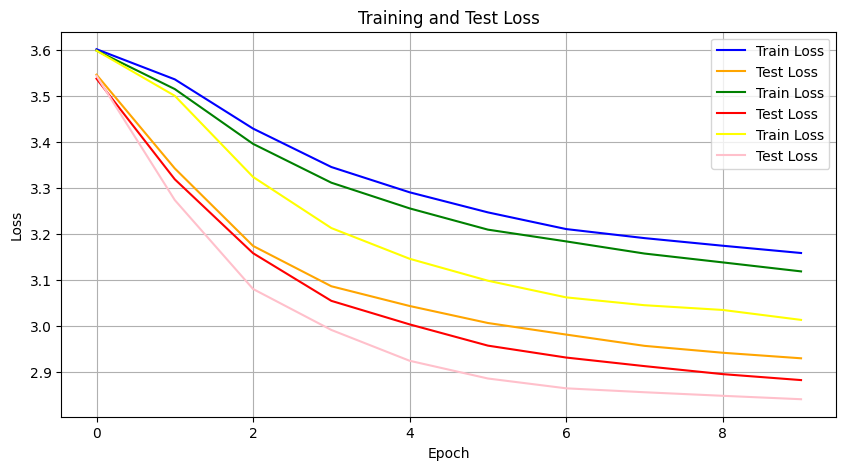

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_vgg16, label='Train Loss', color='blue')
plt.plot(test_loss_history_vgg16, label='Test Loss', color='orange')
plt.plot(train_loss_history_vgg19, label='Train Loss', color='green')
plt.plot(test_loss_history_vgg19, label='Test Loss', color='red')
plt.plot(train_loss_history_resnet50, label='Train Loss', color='yellow')
plt.plot(test_loss_history_resnet50, label='Test Loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


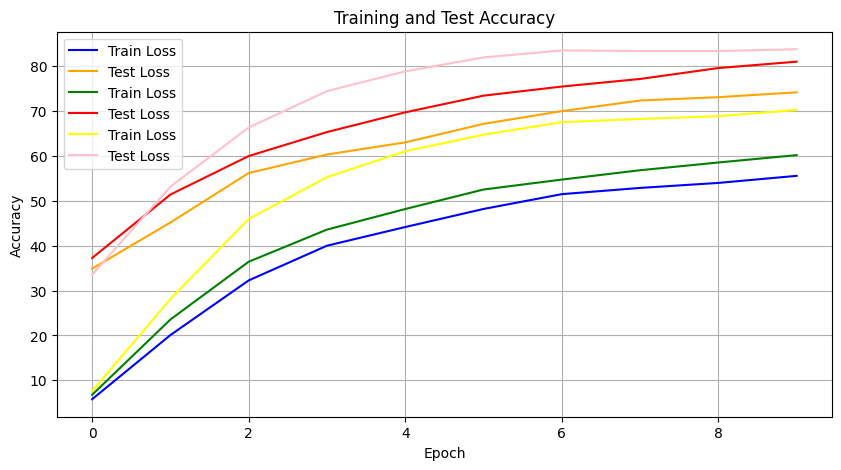

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history_vgg16, label='Train Loss', color='blue')
plt.plot(test_acc_history_vgg16, label='Test Loss', color='orange')
plt.plot(train_acc_history_vgg19, label='Train Loss', color='green')
plt.plot(test_acc_history_vgg19, label='Test Loss', color='red')
plt.plot(train_acc_history_resnet50, label='Train Loss', color='yellow')
plt.plot(test_acc_history_resnet50, label='Test Loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_predicted_and_true_labels(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels, true_labels

predicted_labels, true_labels = get_predicted_and_true_labels(resnet50_model, test_loader)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

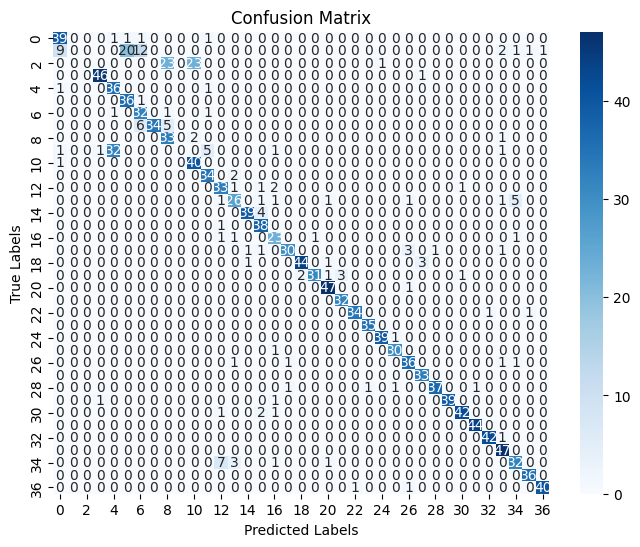

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()